# Set-up

## Imports

In [55]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 200
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# ALE
from alibi.explainers import ALE, plot_ale

## Parameters

In [56]:
scope = 'BID'
input_path = f'../data/3_output/ML_dataset_{scope}.pkl'

train_years = [2021]
test_years = [2022]

subsample_frac = 0.1

target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'SolarAngle',
    'DeclAngle',
    'PVold',
    'PVnew',
    'PriceDiff',
]

features = other_features + features_to_encode

# Main

## Load data

In [57]:
input_df = pd.read_pickle(input_path)
print("{:,}".format(len(input_df)))
input_df.head(3)

2,177,292


,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result
2018010118UP_ALTOADDA_1_BID,18,20180101,2018,UP_ALTOADDA_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,76.773894,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.349,False
2018010119UP_ALTOADDA_1_BID,19,20180101,2018,UP_ALTOADDA_1,BID,1.249924,0.598779,-1.772487,-0.866850,0.891173,...,91.773894,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.329,False
2018010120UP_ALTOADDA_1_BID,20,20180101,2018,UP_ALTOADDA_1,BID,0.243493,0.768175,-1.758348,-0.872364,-0.334594,...,106.773894,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.324,False


In [58]:
# Subsample
if subsample_frac is not None:
    print(f'Subsampled {100*subsample_frac:.0f}% rows from the input dataset')
    df = input_df.sample(frac=subsample_frac)
else:
    df = input_df.copy()

print('Input dataset is composed of {:,} observations'.format(len(input_df)))
print('{:.1%} bids accepted in the input dataset\n'.format(input_df[target].sum() / len(input_df)))

train_df = df[df.year.isin(train_years)]
print('Training data is composed of {:,} observations and correspond to years {}'.format(len(train_df), ' '.join([str(year) for year in train_years])))
print('{:.1%} bids accepted in the training data\n'.format(train_df[target].sum() / len(train_df)))

test_df = df[df.year.isin(test_years)]
# test_df.dropna(subset=['PriceDiff'], inplace=True) # HOTFIX
# test_df = test_df[~(test_df == np.inf).any(axis=1)] # HOTFIX
print('Test data is composed of {:,} observations and correspond to years {}'.format(len(test_df), ' '.join([str(year) for year in test_years])))
print('{:.1%} bids accepted in the test data'.format(test_df[target].sum() / len(test_df)))

Subsampled 10% rows from the input dataset
Input dataset is composed of 2,177,292 observations
15.9% bids accepted in the input dataset

Training data is composed of 39,426 observations and correspond to years 2021
19.6% bids accepted in the training data

Test data is composed of 33,062 observations and correspond to years 2022
17.7% bids accepted in the test data


In [59]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False
)

X_train = feature_transformer.fit_transform(train_df[features])
y_train = train_df[target]

X_test = feature_transformer.transform(test_df[features])
y_test = test_df[target]

print('Input features are:')
print(feature_transformer.feature_names_in_)

Input features are:
['hour' 'SC_PC1' 'SC_PC2' 'IN_PC1' 'IN_PC2' 'CT_PC1' 'CT_PC2' 'PurchMGP'
 'SellMGP' 'SolarAngle' 'DeclAngle' 'PVold' 'PVnew' 'PriceDiff' 'MargTech'
 'WorkDay' 'Prov' 'Tech']


## Load model

In [60]:
model_path = '{}/model_dumps/model_trained_{}_{}.joblib'.format(scope, scope, '_'.join([str(year) for year in train_years]))
clf = joblib.load(model_path)
print(f'Model {model_path} loaded\n')

Model BID/model_dumps/model_trained_BID_2021.joblib loaded



## Permutation Feature Importance

In [61]:
clf_pipeline = make_pipeline(feature_transformer, clf)

In [63]:
train_result = permutation_importance(
    clf_pipeline, train_df[features], y_train, scoring='average_precision', random_state=42, n_jobs=-1
)

In [62]:

test_result = permutation_importance(
    clf_pipeline, test_df[features], y_test, scoring='average_precision', random_state=42, n_jobs=-1
)

In [64]:
sorted_importances_idx = train_result.importances_mean.argsort()

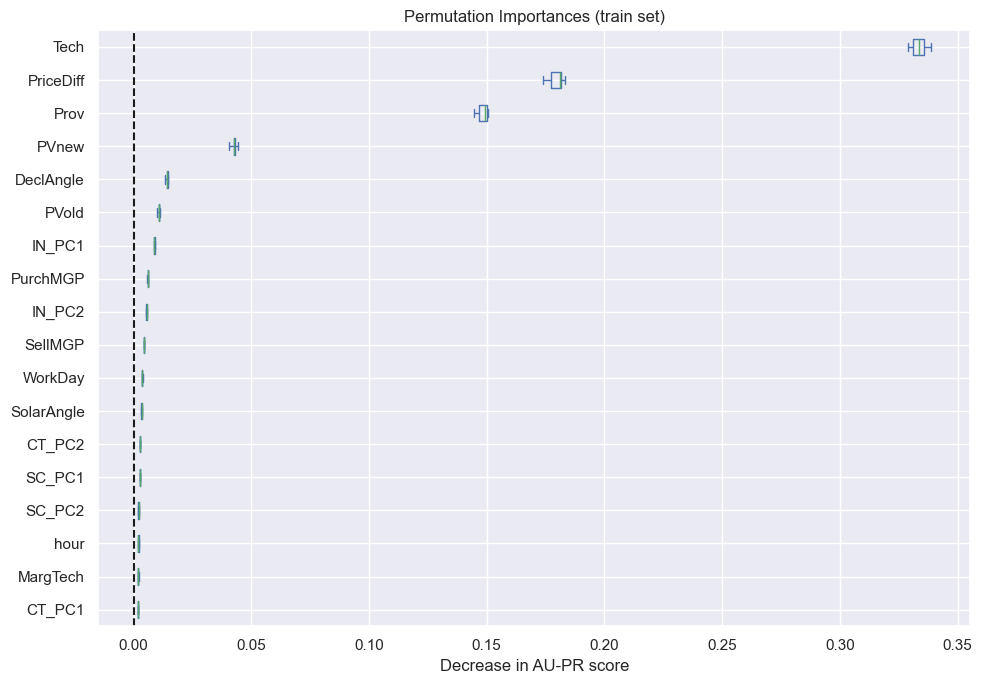

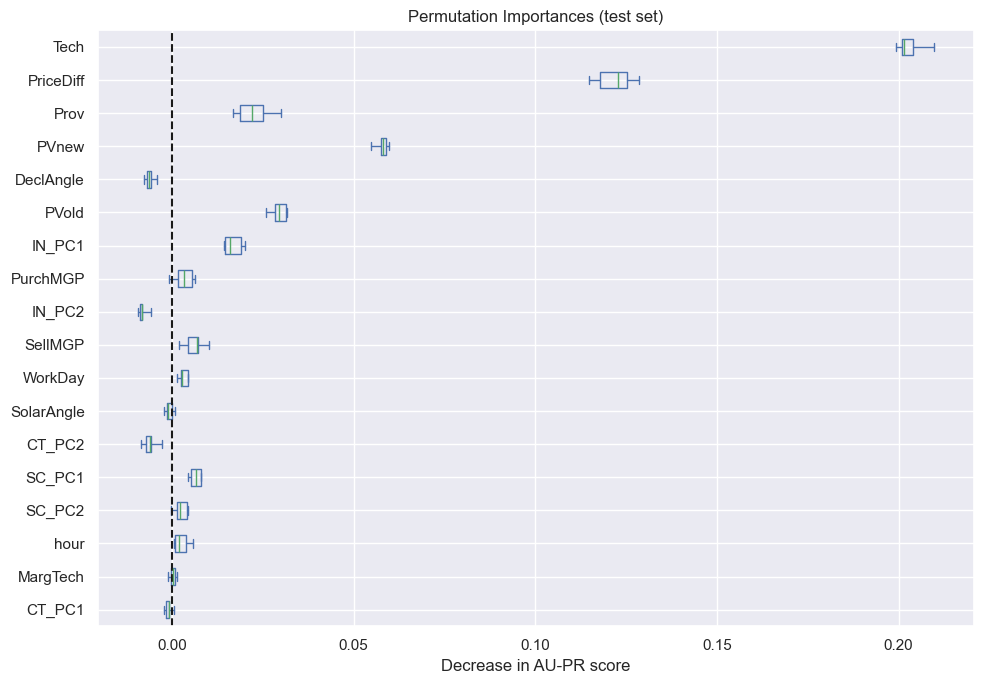

In [65]:
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=train_df[features].columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=train_df[features].columns[sorted_importances_idx],
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
# for name, importances in zip(["train"], [train_importances]):
    ax = importances.plot.box(vert=False, whis=10, figsize=(10,7))
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in AU-PR score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

In [66]:
test_importances

,CT_PC1,MargTech,hour,SC_PC2,SC_PC1,CT_PC2,SolarAngle,WorkDay,SellMGP,IN_PC2,PurchMGP,IN_PC1,PVold,DeclAngle,PVnew,Prov,PriceDiff,Tech
0,-0.001699,-0.001106,0.005806,0.001503,0.006533,-0.007244,0.000961,0.002633,0.006947,-0.008208,0.006320,0.019096,0.029392,-0.005632,0.057591,0.030091,0.117743,0.201450
1,-0.000812,0.001438,0.000565,0.004327,0.005195,-0.008484,-0.002061,0.002783,0.001851,-0.008798,-0.000886,0.014728,0.026004,-0.006715,0.054917,0.016858,0.122800,0.199162
2,-0.000724,-0.000233,0.001942,-0.000196,0.004326,-0.002779,-0.001464,0.001341,0.004515,-0.008192,0.003373,0.014460,0.031288,-0.004035,0.059031,0.022065,0.128542,0.209772
3,-0.002088,0.000445,0.000772,0.004287,0.008005,-0.005834,0.000105,0.004471,0.010111,-0.009343,0.005501,0.020099,0.028439,-0.007559,0.058153,0.025071,0.125191,0.203882
4,0.000532,0.000782,0.003803,0.002232,0.008001,-0.005961,-0.001064,0.004344,0.007252,-0.005749,0.001740,0.016095,0.031778,-0.006243,0.059868,0.018879,0.114771,0.200879


## Partial Dependence Plot

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_85766/1452170413.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  disp.figure_.axes[1].set_xticklabels(xtick_names)


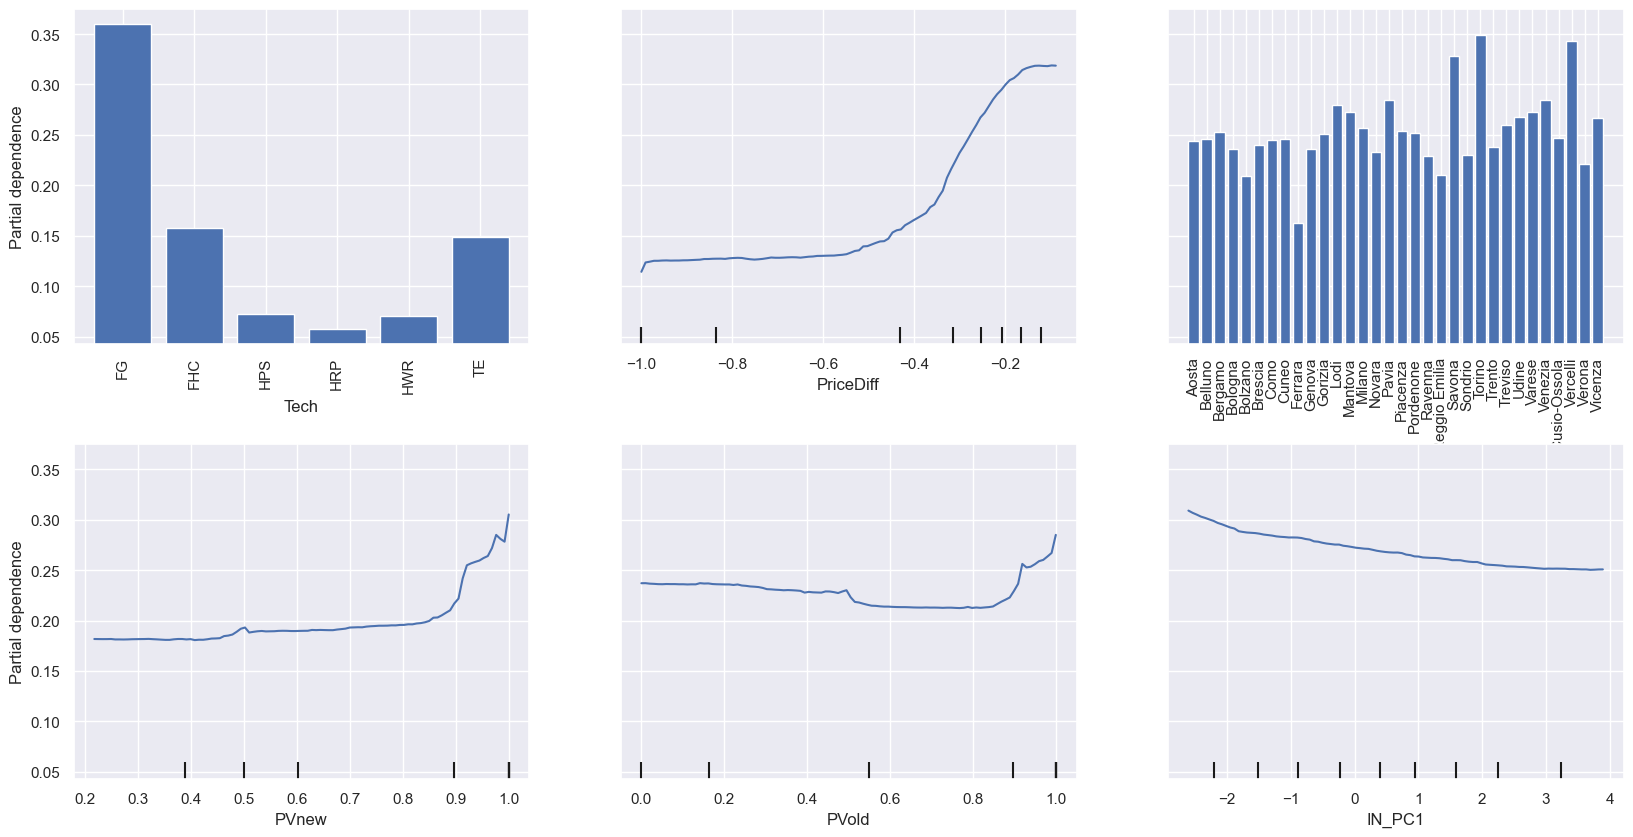

In [69]:
disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['Tech', 'PriceDiff', 'Prov', 'PVnew', 'PVold', 'IN_PC1'],
    categorical_features = np.array([col in features_to_encode for col in test_df[features].columns.to_list()]),
    n_jobs = -1,
    kind = ['average', 'average', 'average', 'average', 'average', 'average'],
    subsample = 100,
)

xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
disp.figure_.axes[1].set_xticklabels(xtick_names)
disp.figure_.set_size_inches(20, 10)
disp.figure_.subplots_adjust(hspace=0.3)

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_85766/2724219383.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  disp.figure_.axes[1].set_xticklabels(xtick_names)


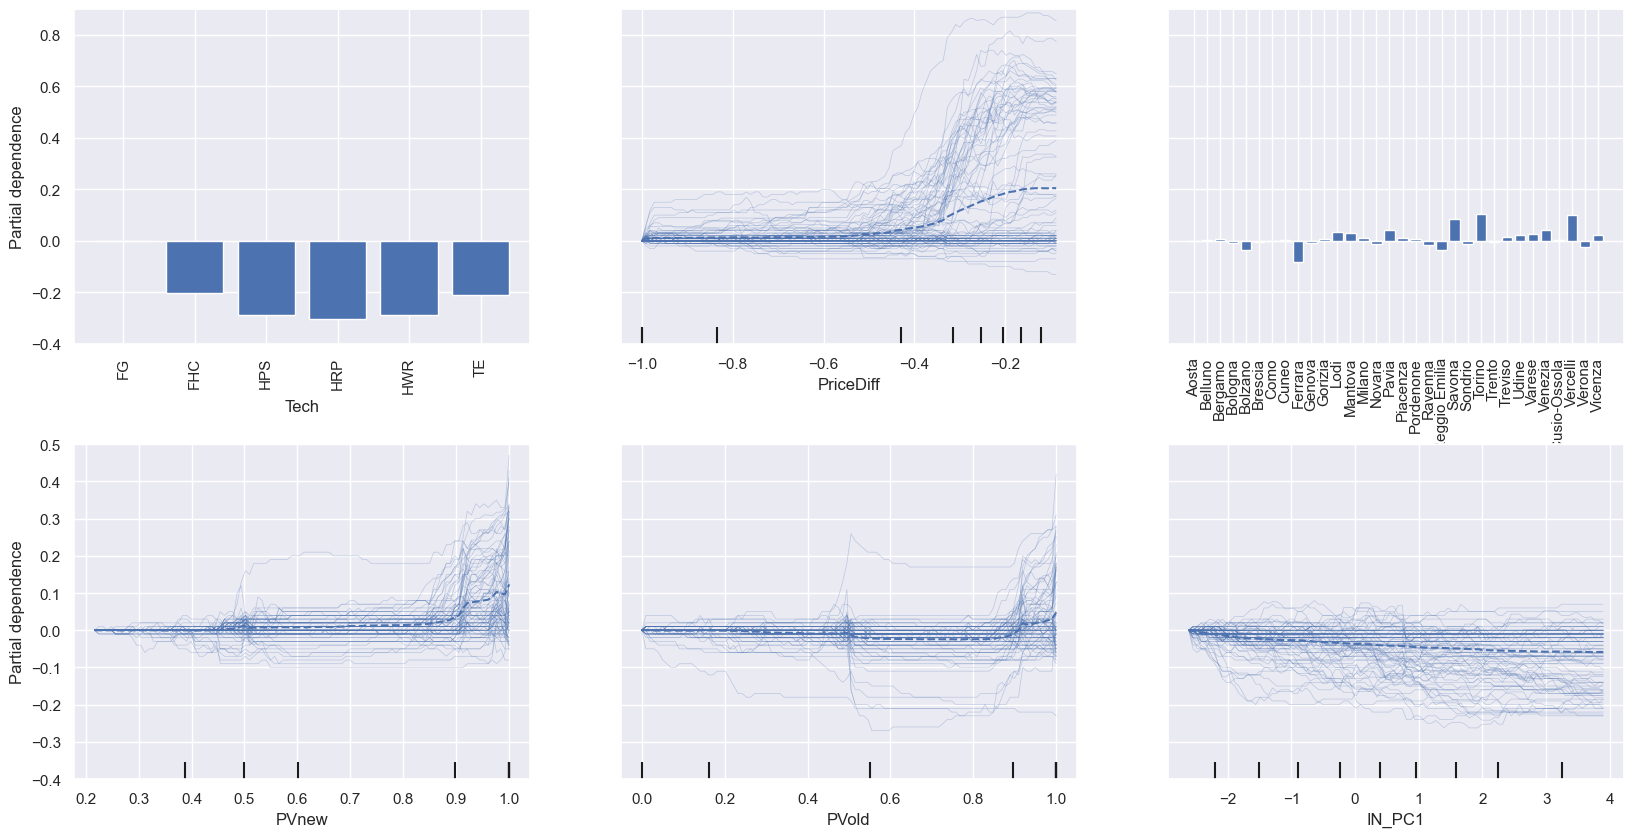

In [72]:
disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['Tech', 'PriceDiff', 'Prov', 'PVnew', 'PVold', 'IN_PC1'],
    categorical_features = np.array([col in features_to_encode for col in test_df[features].columns.to_list()]),
    n_jobs = -1,
    kind = ['average', 'both', 'average', 'both', 'both', 'both'],
    subsample = 100,
    centered=True
)

# Display settings for OFF
# for ax in disp.figure_.axes:
#     ax.set_ylim(-.7,.3)
#     if ax.get_xlabel() in ['PVold', 'Prov']:
#         ax.set_ylim(-.2,.8)

# Display settings for BID
for ax in disp.figure_.axes:
    ax.set_ylim(-.4,.9)
    if ax.get_xlabel() in ['PVnew', 'PVold', 'IN_PC1']:
        ax.set_ylim(-.4,.5)
xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
disp.figure_.axes[1].set_xticklabels(xtick_names)
disp.figure_.set_size_inches(20, 10)
disp.figure_.subplots_adjust(hspace=0.3)

## Accumulated Local Effects (ALE)

In [75]:
predictor = clf.predict_proba

# Features to explain should be numerical or ordinal
encoded_feature_names = list(feature_transformer.get_feature_names_out())
features_to_explain = [encoded_feature_names.index(feature) for feature in ['PVold', 'PVnew', 'PriceDiff', 'IN_PC1']]

ale = ALE(predictor, encoded_feature_names, target_names=['Rejected', 'Accepted'])
ale = ale.explain(X_test.toarray(), features=features_to_explain)

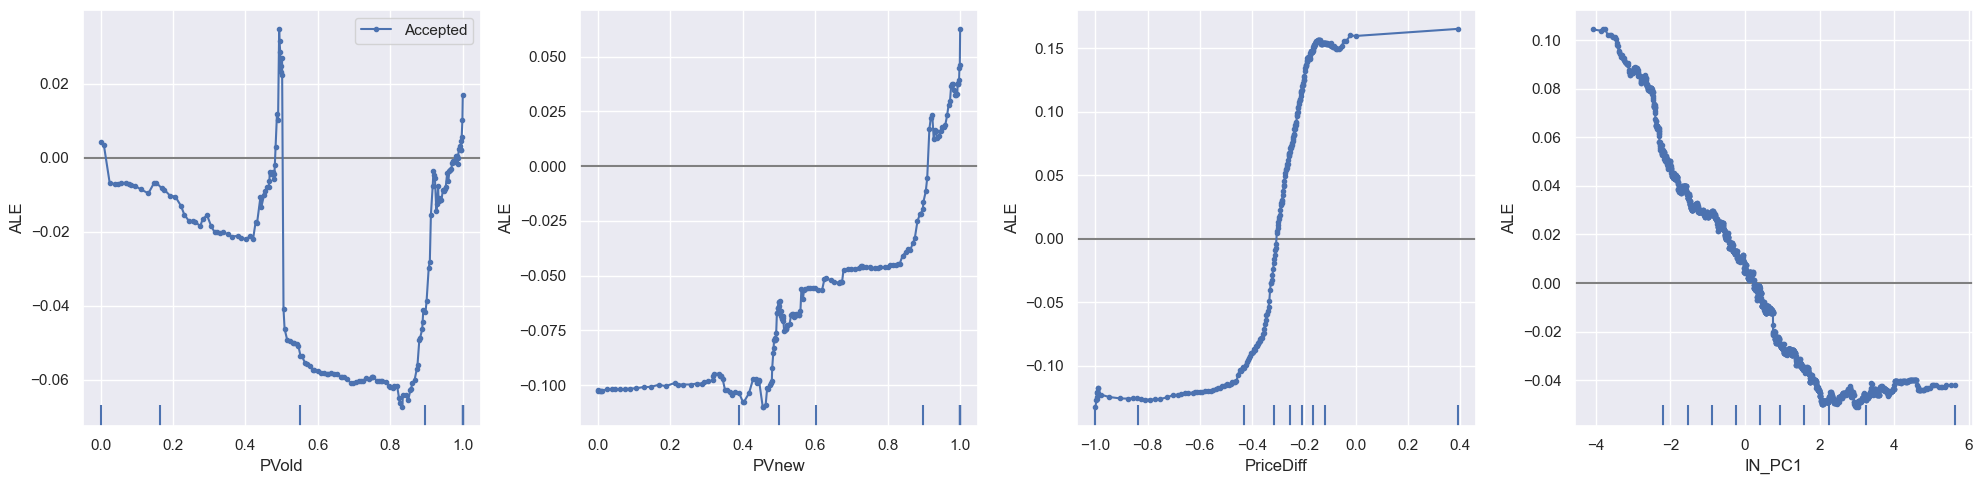

In [77]:
plot_ale(ale, targets=['Accepted'], n_cols=4, fig_kw={'figwidth': 20, 'figheight': 5}, sharey=None)
plt.tight_layout()